Finding Dominant Color Names from Color Space Coordinates and Images
=========================================

![](jupysmug.png)

### Let's install some software.

This notebook will explore various techniques for analyzing the contents of digital images
and computing:

1.  Color names from RGB color space coordinates.

2.  Finding a color "nearest" a preset palette of colors.

3.  Computing an image's dominant color and returning a "nearest" color name.

The methods tested here were collected from many 
sources, ["Lesser artists borrow, great artists steal."](https://www.brainyquote.com/quotes/igor_stravinsky_137813)
One of these days I will have to blog about the difference between ***programming***, *thinking for yourself*,
and ***gargling***, *looking up code snippets on the web.* 

Testing disparate code snippets always turns into a configuration exercise.
The following install commands gather required packages that I didn't find in the Anaconda distribution.

In [1]:
!cd \anaconda3
!python -m pip install webcolors

In [2]:
!cd \anaconda3
!python -m pip install Pillow

### Notebook Imports

In [3]:
import webcolors
import numpy as np
import struct
from PIL import Image
from matplotlib import pyplot as plt
import scipy
import scipy.misc
import scipy.cluster
from collections import namedtuple
from math import sqrt
import random
from sklearn.cluster import KMeans
import random

### Using `webcolors` to Reverse Color Code.

After installing `webcolors` test it with this code snippet from [Stack Overflow](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python).

In [4]:
# modified to return distance from actual color
def closest_color(requested_color):
    min_colors = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return (min_colors[min(min_colors.keys())], sqrt(min(min_colors.keys()))) 

def get_color_name(requested_color):
    try:
        rgb_distance = 0
        closest_name = actual_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
        closest_name , rgb_distance = closest_color(requested_color)
        actual_name = None
    return (actual_name, closest_name, rgb_distance)

requested_color = (119, 172, 152)
actual_name, closest_name , rgb_distance = get_color_name(requested_color)

print("Actual color name:", actual_name, ", closest color name:", closest_name, " rgb distance:", rgb_distance)

Actual color name: None , closest color name: cadetblue  rgb distance: 28.91366458960192


In [5]:
rgb0 = (0,0,0)
rgb1 = (255,255,255)
rgb2 = (255,0,0)
rgb3 = (0,255,0)
rgb4 = (0,0,255)

print(get_color_name(rgb0))
print(get_color_name(rgb1))
print(get_color_name(rgb2))
print(get_color_name(rgb3))
print(get_color_name(rgb4))

('black', 'black', 0)
('white', 'white', 0)
('red', 'red', 0)
('lime', 'lime', 0)
('blue', 'blue', 0)


### Generate Some Random Colors

In [6]:
print(random.randint(0, 255))

147


In [7]:
for a,b in 15 * [(0,255)]:
    rgb = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    print(get_color_name(rgb)[1:])

('indianred', 45.760244754590204)
('cadetblue', 33.46640106136302)
('darkslateblue', 20.42057785666214)
('pink', 34.26368339802363)
('lightgrey', 28.178005607210743)
('navy', 7.3484692283495345)
('teal', 18.138357147217054)
('cornflowerblue', 30.56141357987225)
('limegreen', 32.31098884280702)
('yellowgreen', 23.600847442411894)
('rosybrown', 28.178005607210743)
('brown', 46.49731175025068)
('darkslategrey', 27.367864366808018)
('tan', 8.06225774829855)
('firebrick', 23.430749027719962)


### Loading Test Images

The following images, selected from the 
directories [generated by](https://github.com/bakerjd99/smugpyter/blob/master/notebooks/smugpyter.py) `SmugPyter`,
will be used to test various dominant color calculations.

In [8]:
image1 = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
image2 = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')
image3 = Image.open('C:/SmugMirror/People/GreatandGreaterForebearers/LX8HmDV-2z-william-evert-baker-portrait-1950.jpg')
image4 = Image.open('C:/SmugMirror/Themes/Manipulations/Panoramas/b36sc3H-1-norris-porcelain-basin-yellowstone-panorma.jpg')

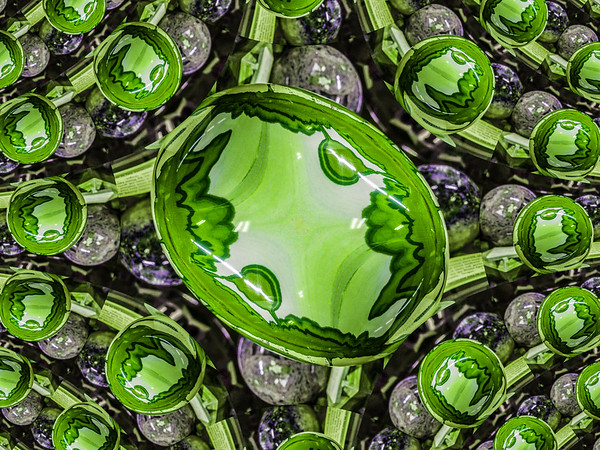

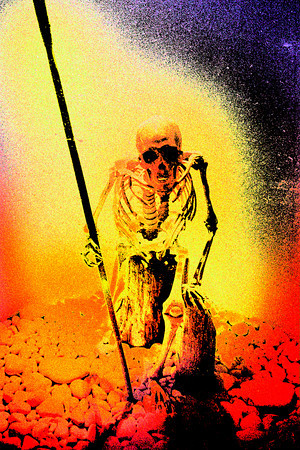

In [9]:
display(image1)
display(image2)

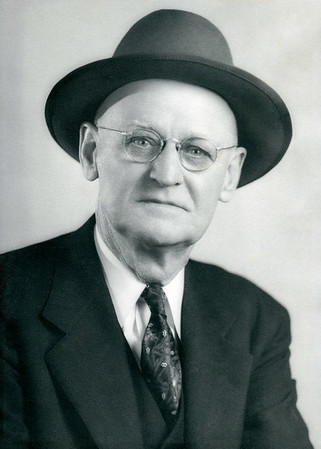

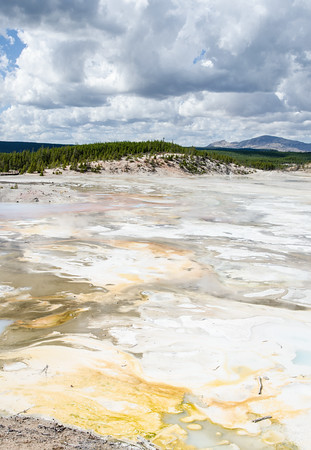

In [10]:
display(image3)
display(image4)

### Define Display Utilities

Before running through the dominant color calculations let's define a few display utilities.

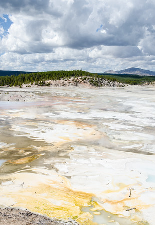

In [11]:
def resize_image(image, factor):
    """Resize PIL image maintaining aspect ratio."""
    imcopy = image.copy()
    width, height = imcopy.size
    width = int(factor * width)
    height = int(factor * height) 
    return imcopy.resize((width, height))

imnew = resize_image(image4, 0.5)
display(imnew)

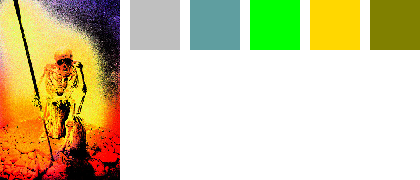

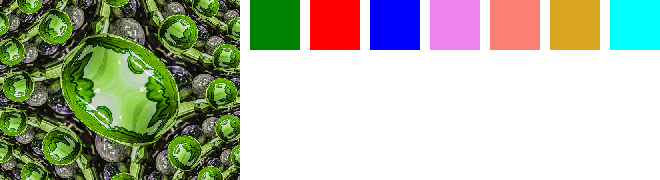

In [12]:
def show_image_name_colors(image, color_names, *, factor=0.4, patch_size=(50,50), spacing=10):
    """Display resized image with adjacent named color patches."""
    imnew = resize_image(image, factor)
    # NIMP check that image is larger than patch size
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(color_names)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    for i, name in enumerate(color_names):
        patch = Image.new("RGB", patch_size, name)
        background.paste(patch, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
    display(background)

show_image_name_colors(image2, ["silver","cadetblue","lime","gold","olive"])
show_image_name_colors(image1, ["green","red","blue","violet","salmon","goldenrod","cyan"])    

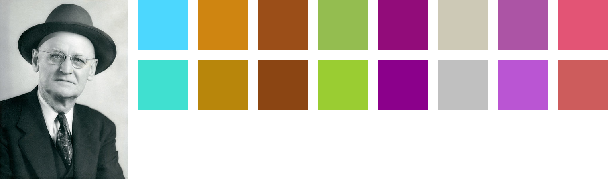

[48.38388161361178, 23.790754506740637, 19.026297590440446, 34.52535300326414, 21.95449840010015, 18.708286933869708, 48.093658625644196, 34.249087579087416]
mean:         31.0914772816
variance:     130.695040448
standard dev: 11.43219316


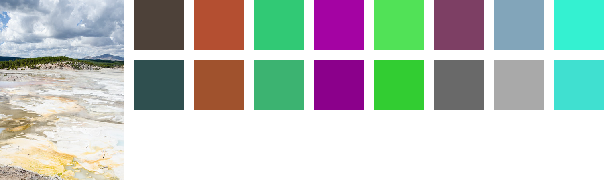

[39.74921382870358, 20.615528128088304, 24.919871588754223, 34.785054261852174, 52.640288753007425, 46.78675026115834, 42.731721238442994, 20.83266665599966]
mean:         35.3826368395
variance:     130.069010284
standard dev: 11.4047801506


In [13]:
def show_image_colors(image, colors, *, factor=0.4, patch_size=(50,50), spacing=10):
    """
    Display resized image with adjacent color patches.
    The top patch row shows raw colors and the second
    shows nearest named colors.
    """
    imnew = resize_image(image, factor)
    # NIMP check that image is 2 * larger than patch size.
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(colors)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    rgb_distance = []
    for i, color in enumerate(colors):
        r, g, b = color
        patch1 = Image.new("RGB", patch_size, (int(r),int(g),int(b)))
        background.paste(patch1, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
        name , rgb_metric = get_color_name((r,g,b))[1:]
        rgb_distance.append(rgb_metric)
        patch2 = Image.new("RGB", patch_size, name)
        background.paste(patch2, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), spacing + patch_size[1]))
    display(background)
    print(rgb_distance)
    print("mean:         %s" % np.mean(rgb_distance))
    print("variance:     %s" % np.var(rgb_distance))
    print("standard dev: %s" % np.std(rgb_distance))

rcolors0 = []
rcolors1 = []
for a,b in 8 * [(0,255)]:
    rgb0 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    rgb1 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    rcolors0.append(rgb0)
    rcolors1.append(rgb1)
    
show_image_colors(image3, rcolors0)
show_image_colors(image4, rcolors1)    

### First Dominant Color Calculation

After making some minor code edits it's possible to 
run this [algorithm from Stack Overflow](https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image).

In [14]:
def array_from_image(image, *, factor=0.4):
    image = resize_image(image, factor)
    ar = np.asarray(image)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    return ar

def calc1_colors(ar, *, num_clusters=8, factor=0.4):
    colors, dist = scipy.cluster.vq.kmeans(ar, num_clusters)
    return colors

def calc1_peak(ar, colors):
    vecs, dist = scipy.cluster.vq.vq(ar, colors)        # assign codes
    counts, bins = scipy.histogram(vecs, len(colors))   # count occurrences
    index_max = scipy.argmax(counts)                    # find most frequent
    peak = colors[index_max]
    return peak

def calc1_colors_peak(image, *, num_clusters=8, factor=0.4):
    ar = array_from_image(image, factor=factor)
    colors = calc1_colors(ar, num_clusters=num_clusters)
    peak = calc1_peak(ar, colors)
    return (colors, peak)
    
NUM_CLUSTERS = 8

calc1_colors1, calc1_peak1 = calc1_colors_peak(image1, num_clusters=NUM_CLUSTERS) 
calc1_colors2, calc1_peak2 = calc1_colors_peak(image2, num_clusters=NUM_CLUSTERS) 
calc1_colors3, calc1_peak3 = calc1_colors_peak(image3, num_clusters=NUM_CLUSTERS) 
calc1_colors4, calc1_peak4 = calc1_colors_peak(image4, num_clusters=NUM_CLUSTERS) 

print('peak1', calc1_peak1)
print('peak2', calc1_peak2)
print('peak3', calc1_peak3)
print('peak4', calc1_peak4)

peak1 [ 18.01530285  23.57023733  10.54815358]
peak2 [ 241.60874595  224.36117538  131.87251273]
peak3 [ 224.87512176  226.90005845  223.25073057]
peak4 [ 240.04061766  238.60557234  234.21097684]


### Display Cluster and Named Colors for the First Calculation

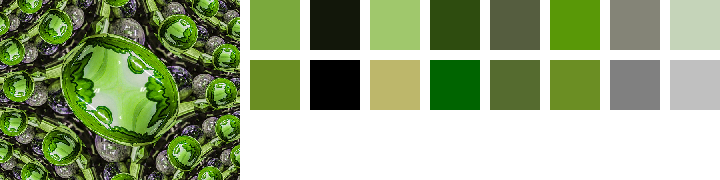

[41.743911872385375, 31.48604085227139, 33.64357495028607, 54.43594926431318, 21.67016569418164, 34.188555506572776, 10.631621185991921, 22.053177359700104]
mean:         31.2316245857
variance:     157.950008767
standard dev: 12.5678163882


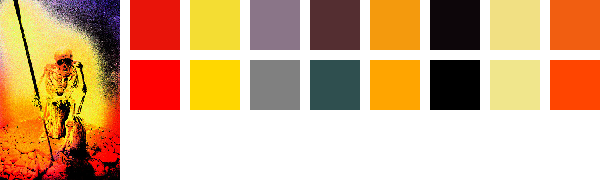

[31.446712918124415, 52.98128557069906, 16.861205708267363, 57.0102960027411, 19.89565717603528, 18.295708031602786, 10.021998603351154, 34.019901735553994]
mean:         30.0665957183
variance:     260.843666823
standard dev: 16.1506553063


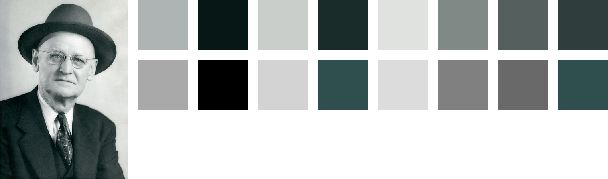

[15.61200218064867, 33.241042891262644, 12.798764284360711, 54.236337472057215, 9.05234046830287, 11.872101962163239, 24.523194244375507, 25.242541928682886]
mean:         23.322290679
variance:     195.515115748
standard dev: 13.9826719817


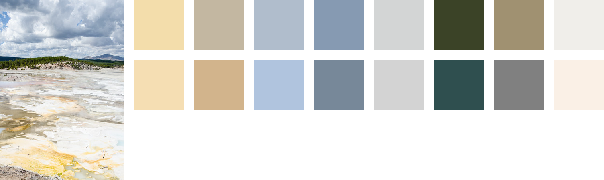

[7.20863508945083, 26.353072449597743, 18.562475890885047, 34.70344464522176, 3.04955977460228, 43.08455646466423, 39.90104359023368, 10.90257084747591]
mean:         22.970669844
variance:     206.333524427
standard dev: 14.3643142693


In [15]:
show_image_colors(image1, calc1_colors1)   
show_image_colors(image2, calc1_colors2)
show_image_colors(image3, calc1_colors3)
show_image_colors(image4, calc1_colors4)

### Second Dominant Color Calculation

This algorithm, due to [Charlies Leifer](https://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/), also computes dominant colors.

In [16]:
Point = namedtuple('Point', ('coords', 'n', 'ct'))
Cluster = namedtuple('Cluster', ('points', 'center', 'n'))

def get_points(img):
    points = []
    w, h = img.size
    for count, color in img.getcolors(w * h):
        points.append(Point(color, 3, count))
    return points

rtoh = lambda rgb: '#%s' % ''.join(('%02x' % p for p in rgb))

def calc2_colors(image, *, num_clusters=8, factor=0.4):
    img = resize_image(image, factor)
    w, h = img.size

    points = get_points(img)
    clusters = kmeans(points, num_clusters, 1)
    rgbs = [map(int, c.center.coords) for c in clusters]
    return map(rtoh, rgbs)

def euclidean(p1, p2):
    return sqrt(sum([
        (p1.coords[i] - p2.coords[i]) ** 2 for i in range(p1.n)
    ]))

def calculate_center(points, n):
    vals = [0.0 for i in range(n)]
    plen = 0
    for p in points:
        plen += p.ct
        for i in range(n):
            vals[i] += (p.coords[i] * p.ct)
    return Point([(v / plen) for v in vals], n, 1)

def kmeans(points, k, min_diff):
    clusters = [Cluster([p], p, p.n) for p in random.sample(points, k)]

    while 1:
        plists = [[] for i in range(k)]

        for p in points:
            smallest_distance = float('Inf')
            for i in range(k):
                distance = euclidean(p, clusters[i].center)
                if distance < smallest_distance:
                    smallest_distance = distance
                    idx = i
            plists[idx].append(p)

        diff = 0
        for i in range(k):
            old = clusters[i]
            center = calculate_center(plists[i], old.n)
            new = Cluster(plists[i], center, old.n)
            clusters[i] = new
            diff = max(diff, euclidean(old.center, new.center))

        if diff < min_diff:
            break

    return clusters

In [17]:
dmap1 = calc2_colors(image1, num_clusters=8)
dmap2 = calc2_colors(image2, num_clusters=8)
dmap3 = calc2_colors(image3, num_clusters=8)
dmap4 = calc2_colors(image4, num_clusters=8)
colors1 = [webcolors.hex_to_rgb(i) for i in list(dmap1)]
colors2 = [webcolors.hex_to_rgb(i) for i in list(dmap2)]
colors3 = [webcolors.hex_to_rgb(i) for i in list(dmap3)]
colors4 = [webcolors.hex_to_rgb(i) for i in list(dmap4)]

### Display Cluster and Named Colors for the Second Calculation

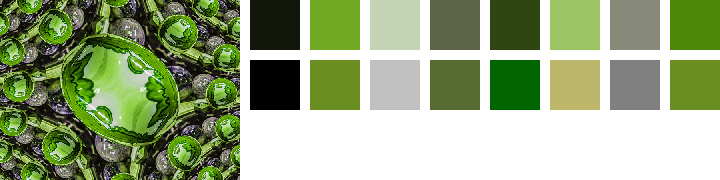

[30.298514815086232, 28.653097563788805, 23.173260452512935, 25.709920264364882, 58.90670590009256, 38.7556447501522, 14.594519519326424, 42.35563716909474]
mean:         32.8059125543
variance:     163.272101479
standard dev: 12.7777972076


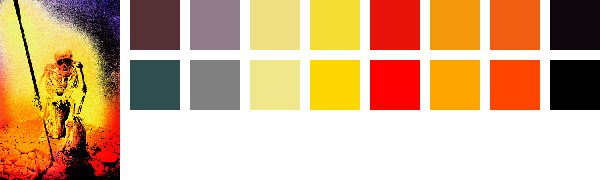

[54.954526656136345, 20.049937655763422, 10.862780491200215, 52.51666402200353, 31.78049716414141, 20.223748416156685, 33.31666249791537, 18.2208671582886]
mean:         30.2407105077
variance:     230.374427989
standard dev: 15.1780903934


In [18]:
show_image_colors(image1, colors1)
show_image_colors(image2, colors2)

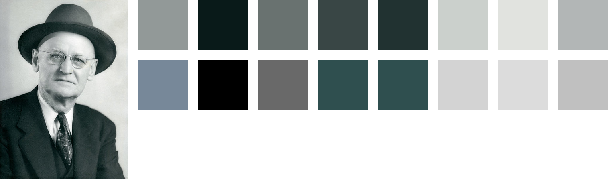

[31.921779399024736, 37.17526059088221, 11.40175425099138, 16.76305461424021, 44.01136216933077, 11.045361017187261, 9.1104335791443, 19.8997487421324]
mean:         22.6660942954
variance:     154.998169394
standard dev: 12.4498260788


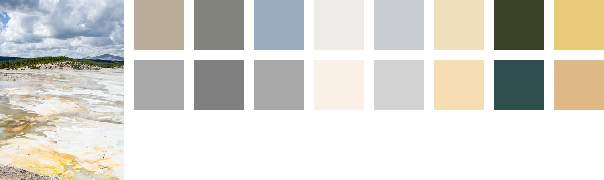

[22.978250586152114, 5.196152422706632, 27.94637722496424, 13.0, 11.832159566199232, 9.486832980505138, 45.088801270381985, 25.88435821108957]
mean:         20.1766165327
variance:     147.65414529
standard dev: 12.1513022055


In [19]:
show_image_colors(image3, colors3)
show_image_colors(image4, colors4)

## Third Dominant Color Calculation

This algorithm, due to [Srijan Anand](https://github.com/srijannnd/Dominant-Color-Extraction-Dominance-and-Recoloring), is another variation on *kmeans*. The original notebook code required
some changes as `cv2` is not currently available for Python 3.6 Win64 Anaconda systems. It can be replaced
with `PIL`.

In [20]:
km = KMeans(n_clusters=8)
print(km)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [21]:
def calc3_colors(image, num_clusters=8):
    km = KMeans(n_clusters=num_clusters)
    image = resize_image(image, factor=0.4)
    ar = np.asarray(image)
    shape = ar.shape
    pixels = ar.reshape((-1, 3))
    km.fit(pixels)
    colors = np.asarray(km.cluster_centers_, dtype='uint8')
    # improved rounding - has little effect
    #colors = np.asarray(np.around(km.cluster_centers_,0), dtype='uint8')
    return (colors, pixels, km)

def calc3_percentage(pixels, km):
    percentage = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype='float32')
    percentage = percentage/pixels.shape[0]
    return percentage

In [22]:
def calc3_dominance_patch(colors, pixels, km):
    percentage = calc3_percentage(pixels, km)
    dom = [[percentage[ix], colors[ix]] for ix in range(km.n_clusters)]
    dominance = sorted(dom, key=lambda x:x[0], reverse=True)
    plt.figure(0)
    plt.axis("off")
    patch = np.zeros((50, 500, 3))
    start = 0
    names = []
    for cx in range(km.n_clusters):
        da = dominance[cx][0] * patch.shape[1]
        width = int(da)
        end = start + width
        cb = dominance[cx][1]
        # nearest named color
        nc = get_color_name(cb)[1]  
        names.append(nc)
        r, g, b = webcolors.name_to_rgb(nc)
        patch[:, start:end, :] = 255 - np.asarray([r,g,b], dtype=np.uint8)
        start = end
    plt.imshow(patch)
    plt.show()
    print(names)

colors1 , pixels1 , km1 = calc3_colors(image1)
colors2 , pixels2 , km2 = calc3_colors(image2)
colors3 , pixels3 , km3 = calc3_colors(image3)
colors4 , pixels4 , km4 = calc3_colors(image4)

### Display Cluster and Named Colors for the Third Calculation

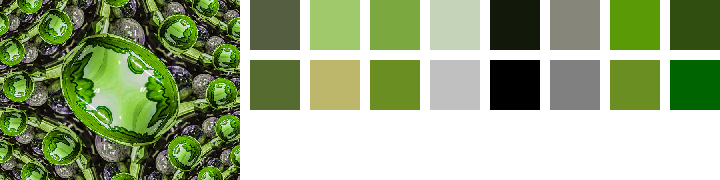

[23.043437243605826, 34.14674215792775, 41.42463035441596, 21.77154105707724, 31.622776601683793, 10.392304845413264, 34.88552708502482, 54.89080068645383]
mean:         31.522220004
variance:     159.474646023
standard dev: 12.6283271268


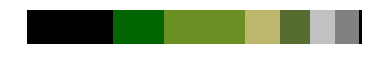

['black', 'darkgreen', 'olivedrab', 'olivedrab', 'darkkhaki', 'darkolivegreen', 'silver', 'grey']


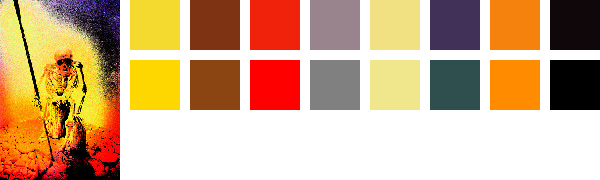

[47.3392015141785, 21.400934559032695, 39.05124837953327, 27.892651361962706, 11.357816691600547, 36.124783736376884, 19.209372712298546, 19.339079605813716]
mean:         27.7143860701
variance:     129.287804757
standard dev: 11.3704795307


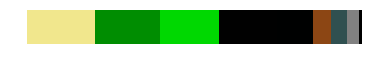

['khaki', 'darkorange', 'gold', 'black', 'red', 'saddlebrown', 'darkslategrey', 'grey']


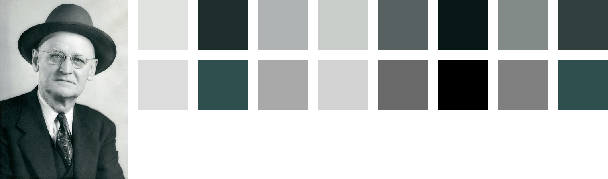

[7.810249675906654, 52.364109846344185, 15.362291495737216, 14.352700094407323, 20.42057785666214, 33.97057550292606, 14.52583904633395, 23.430749027719962]
mean:         22.7796365683
variance:     178.088157818
standard dev: 13.3449675091


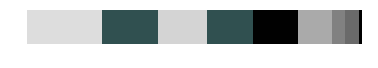

['gainsboro', 'darkslategrey', 'lightgrey', 'darkslategrey', 'black', 'darkgrey', 'grey', 'dimgrey']


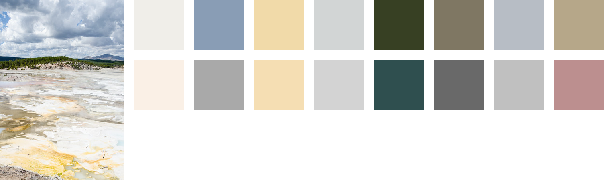

[10.63014581273465, 36.22154055254967, 11.489125293076057, 3.0, 47.16990566028302, 26.758176320519304, 10.723805294763608, 25.45584412271571]
mean:         21.4310678821
variance:     199.459329434
standard dev: 14.123007096


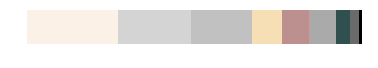

['linen', 'lightgrey', 'silver', 'wheat', 'rosybrown', 'darkgrey', 'darkslategrey', 'dimgrey']


In [23]:
show_image_colors(image1, colors1)
calc3_dominance_patch(colors1, pixels1, km1)
show_image_colors(image2, colors2)
calc3_dominance_patch(colors2, pixels2, km2)
show_image_colors(image3, colors3)
calc3_dominance_patch(colors3, pixels3, km3)
show_image_colors(image4, colors4)
calc3_dominance_patch(colors4, pixels4, km4)

### Named Color Selection Tests

All these *kmeans* algorithms produce similar results. The first and third calculations are faster
than the second which is to be expected from library routines. When the raw colors are mapped
to named colors the shifts can lead to poor choices. To refine the choice this heuristic is employed.

1. Look at the list of named colors. If a named color appears more than once pick the most
   frequently occuring name. For the third calculation "olivedrab" appears twice. I think
   this is a better choice than the dominant most frequent raw color that is mapped to "black."
   
2. If there are no repeated named colors toss out greatest color distance, compute the remaining
   mean and standard deviation. Sort the colors by frequency then pick the first color
   with a distance that is less than or equal one standard deviation from the mean.
   
The following functions implement this method.

In [24]:
def dualsort(a, b, *, reverse=False):
        """
        Sort lists (a) and (b) using (a) to grade (b).
        """
        temp = sorted(zip(a, b), key=lambda x: x[0], reverse=reverse)
        return list(map(list, zip(*temp)))
    
def most_common(lst):
        """ Pick most common item in a list - ok for small lists."""
        return max(set(lst), key=lst.count)

def cluster_name_freq_dist(image, *, num_clusters=8, factor=0.4):
        """
        Returns a tuple of sorted nearest named colors, cluster frequencies, and
        distances from cluster raw colors. Items are sorted by decreasing
        cluster frequency.
        """
        km = KMeans(n_clusters=num_clusters)
        imcopy = resize_image(image, factor=factor)
        ar = np.asarray(imcopy)
        pixels = ar.reshape((-1, 3))
        km.fit(pixels)
        colors = np.asarray(km.cluster_centers_, dtype=np.uint8)
        frequencies = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype=np.int32)
        names = []
        distances = []
        for color in colors:
            _ , name , rgb_distance = get_color_name(color)
            names.append(name)
            distances.append(rgb_distance)
        # order by decreasing frequency
        _ , names = dualsort(frequencies, names, reverse=True)
        frequencies , distances = dualsort(frequencies, distances, reverse=True)
        return (names, frequencies, distances)

def dominant_color_key(names_freqs_dists):
        """
        Return a single dominant color key.
        """
        names , frequencies , distances = names_freqs_dists
       
        if len(names) > len(list(set(names))):
            # most frequent repeated named color
            key = most_common(names)
        else:
            # distances less greatest outlier
            dist_sample = sorted(distances, reverse=True)[1:]
            threshold = np.mean(dist_sample) + np.std(dist_sample)
            
            # default color choice
            key = names[0]
            
            # return first color from sorted names that is no more
            # than one standard deviation from the sample mean. If
            # no such choice is made retain the default selection.
            for name, distance in zip(names, distances): 
                if distance <= threshold:
                    key = name
                    break
                
        return key.lower().strip()
    
names_freq_dist = cluster_name_freq_dist(image1)
print(dominant_color_key(names_freq_dist))

olivedrab


### Frequencies of Color Keys

I applied this method to all the sample images in my `c:/SmugMirror` directories and analyzed
the color assignments. The following table summarizes the results.

        +-----+-----------------------+---------+-----------+-----------+-------+
        |count|color key              |frequency|percent    |cummulative|reverse|
        +-----+-----------------------+---------+-----------+-----------+-------+
        | 1   |`0_darkslategrey       |702      |  16.521534|16.521534  |4249   |
        | 2   |`0_black               |549      |  12.920687|29.442222  |3547   |
        | 3   |`0_dimgrey             |286      |  6.7309955|36.173217  |2998   |
        | 4   |`0_darkgrey            |263      |  6.1896917|42.362909  |2712   |
        | 5   |`0_grey                |250      |  5.8837373|48.246646  |2449   |
        | 6   |`0_darkolivegreen      |244      |  5.7425277|53.989174  |2199   |
        | 7   |`0_silver              |223      |  5.2482937|59.237468  |1955   |
        | 8   |`0_gainsboro           |142      |  3.3419628| 62.57943  |1732   |
        | 9   |`0_lightsteelblue      |139      |   3.271358|65.850788  |1590   |
        |10   |`0_steelblue           |128      |  3.0124735|68.863262  |1451   |
        |11   |`0_lightgrey           |113      |  2.6594493|71.522711  |1323   |
        |12   |`0_rosybrown           |108      |  2.5417745|74.064486  |1210   |
        |13   |`0_lavender            | 94      |  2.2122852|76.276771  |1102   |
        |14   |`0_tan                 | 83      |  1.9534008|78.230172  |1008   |
        |15   |`0_whitesmoke          | 49      |  1.1532125|79.383384  | 925   |
        |16   |`0_lightslategrey      | 48      |  1.1296776|80.513062  | 876   |
        |17   |`0_cornflowerblue      | 48      |  1.1296776|81.642739  | 828   |
        |18   |`0_sienna              | 47      |  1.1061426|82.748882  | 780   |
        |19   |`0_midnightblue        | 39      | 0.91786303|83.666745  | 733   |
        |20   |`0_peru                | 39      | 0.91786303|84.584608  | 694   |
        |21   |`0_lightblue           | 38      | 0.89432808|85.478936  | 655   |
        |22   |`0_linen               | 37      | 0.87079313|86.349729  | 617   |
        |23   |`0_olivedrab           | 32      | 0.75311838|87.102848  | 580   |
        |24   |`0_white               | 30      | 0.70604848|87.808896  | 548   |
        |25   |`0_burlywood           | 30      | 0.70604848|88.514945  | 518   |
        |26   |`0_skyblue             | 30      | 0.70604848|89.220993  | 488   |
        |27   |`0_darkkhaki           | 28      | 0.65897858|89.879972  | 458   |
        |28   |`0_saddlebrown         | 27      | 0.63544363|90.515415  | 430   |
        |29   |`0_wheat               | 27      | 0.63544363|91.150859  | 403   |
        |30   |`0_snow                | 24      | 0.56483879|91.715698  | 376   |
        |31   |`0_darkslateblue       | 21      | 0.49423394|92.209932  | 352   |
        |32   |`0_slategrey           | 20      | 0.47069899|92.680631  | 331   |
        |33   |`0_antiquewhite        | 17      | 0.40009414|93.080725  | 311   |
        |34   |`0_cadetblue           | 16      | 0.37655919|93.457284  | 294   |
        |35   |`0_powderblue          | 15      | 0.35302424|93.810308  | 278   |
        |36   |`0_indianred           | 14      | 0.32948929|94.139798  | 263   |
        |37   |`0_firebrick           | 12      | 0.28241939|94.422217  | 249   |
        |38   |`0_darkseagreen        | 11      | 0.25888444|94.681101  | 237   |
        |39   |`0_maroon              | 10      | 0.23534949|94.916451  | 226   |
        |40   |`0_lightskyblue        | 10      | 0.23534949|  95.1518  | 216   |
        |41   |`0_ghostwhite          |  9      | 0.21181454|95.363615  | 206   |
        |42   |`0_bisque              |  9      | 0.21181454| 95.57543  | 197   |
        |43   |`0_royalblue           |  8      |  0.1882796|95.763709  | 188   |
        |44   |`0_goldenrod           |  8      |  0.1882796|95.951989  | 180   |
        |45   |`0_chocolate           |  8      |  0.1882796|96.140268  | 172   |
        |46   |`0_sandybrown          |  8      |  0.1882796|96.328548  | 164   |
        |47   |`0_oldlace             |  7      | 0.16474465|96.493293  | 156   |
        |48   |`0_teal                |  7      | 0.16474465|96.658037  | 149   |
        |49   |`0_deepskyblue         |  7      | 0.16474465|96.822782  | 142   |
        |50   |`0_beige               |  6      |  0.1412097|96.963992  | 135   |
        |51   |`0_palegoldenrod       |  6      |  0.1412097|97.105201  | 129   |
        |52   |`0_brown               |  6      |  0.1412097|97.246411  | 123   |
        |53   |`0_thistle             |  6      |  0.1412097|97.387621  | 117   |
        |54   |`0_orangered           |  6      |  0.1412097| 97.52883  | 111   |
        |55   |`0_crimson             |  5      | 0.11767475|97.646505  | 105   |
        |56   |`0_olive               |  5      | 0.11767475| 97.76418  | 100   |
        |57   |`0_darksalmon          |  5      | 0.11767475|97.881855  |  95   |
        |58   |`0_seagreen            |  5      | 0.11767475|97.999529  |  90   |
        |59   |`0_aliceblue           |  5      | 0.11767475|98.117204  |  85   |
        |60   |`0_paleturquoise       |  4      |0.094139798|98.211344  |  80   |
        |61   |`0_khaki               |  4      |0.094139798|98.305484  |  76   |
        |62   |`0_lightyellow         |  3      |0.070604848|98.376088  |  72   |
        |63   |`0_lightgoldenrodyellow|  3      |0.070604848|98.446693  |  69   |
        |64   |`0_darkred             |  3      |0.070604848|98.517298  |  66   |
        |65   |`0_floralwhite         |  3      |0.070604848|98.587903  |  63   |
        |66   |`0_navajowhite         |  3      |0.070604848|98.658508  |  60   |
        |67   |`0_darkgoldenrod       |  3      |0.070604848|98.729113  |  57   |
        |68   |`0_tomato              |  3      |0.070604848|98.799718  |  54   |
        |69   |`0_deeppink            |  3      |0.070604848|98.870322  |  51   |
        |70   |`0_darkcyan            |  3      |0.070604848|98.940927  |  48   |
        |71   |`0_palevioletred       |  3      |0.070604848|99.011532  |  45   |
        |72   |`0_mintcream           |  3      |0.070604848|99.082137  |  42   |
        |73   |`0_mediumblue          |  3      |0.070604848|99.152742  |  39   |
        |74   |`0_pink                |  2      |0.047069899|99.199812  |  36   |
        |75   |`0_gold                |  2      |0.047069899|99.246882  |  34   |
        |76   |`0_darkblue            |  2      |0.047069899|99.293952  |  32   |
        |77   |`0_orchid              |  2      |0.047069899|99.341021  |  30   |
        |78   |`0_lightpink           |  2      |0.047069899|99.388091  |  28   |
        |79   |`0_seashell            |  2      |0.047069899|99.435161  |  26   |
        |80   |`0_mediumseagreen      |  2      |0.047069899|99.482231  |  24   |
        |81   |`0_dodgerblue          |  2      |0.047069899|99.529301  |  22   |
        |82   |`0_lightcyan           |  2      |0.047069899|99.576371  |  20   |
        |83   |`0_darkturquoise       |  2      |0.047069899|99.623441  |  18   |
        |84   |`0_red                 |  1      |0.023534949|99.646976  |  16   |
        |85   |`0_yellow              |  1      |0.023534949|99.670511  |  15   |
        |86   |`0_cornsilk            |  1      |0.023534949|99.694046  |  14   |
        |87   |`0_mistyrose           |  1      |0.023534949|99.717581  |  13   |
        |88   |`0_mediumaquamarine    |  1      |0.023534949|99.741116  |  12   |
        |89   |`0_plum                |  1      |0.023534949|99.764651  |  11   |
        |90   |`0_darkmagenta         |  1      |0.023534949|99.788185  |  10   |
        |91   |`0_hotpink             |  1      |0.023534949| 99.81172  |   9   |
        |92   |`0_peachpuff           |  1      |0.023534949|99.835255  |   8   |
        |93   |`0_blanchedalmond      |  1      |0.023534949| 99.85879  |   7   |
        |94   |`0_lavenderblush       |  1      |0.023534949|99.882325  |   6   |
        |95   |`0_blue                |  1      |0.023534949| 99.90586  |   5   |
        |96   |`0_mediumpurple        |  1      |0.023534949|99.929395  |   4   |
        |97   |`0_navy                |  1      |0.023534949| 99.95293  |   3   |
        |98   |`0_slateblue           |  1      |0.023534949|99.976465  |   2   |
        |99   |`0_orange              |  1      |0.023534949|      100  |   1   |
        +-----+-----------------------+---------+-----------+-----------+-------+
        
A number of things are apparent from this test.

1. Only 99 of 147 possible colors appear: about 67%.

2. The first six colors are assigned to over 50% of all images.

3. The first color is assigned more often than the last 79 colors.

4. *kmeans* dominant colors are not particularily meaningful for photographs.

### A Revised Color Selection

To reduce the frequency of the first seven selections the following revised function
accepts these colors only a certain percentage of the time.

In [25]:
over_dominant = ['darkslategrey', 'black', 'dimgrey', 'darkgrey',
                     'grey', 'darkolivegreen', 'silver']

over_threshold = 0.10

def dominant_color_key2(names_freqs_dists):
        """
        Return a single dominant color key.
        """
        names , frequencies , distances = names_freqs_dists
       
        if len(names) > len(list(set(names))):
            # most frequent repeated named color
            key = most_common(names)
        else:
            # distances less greatest outlier
            dist_sample = sorted(distances, reverse=True)[1:]
            threshold = np.mean(dist_sample) + np.std(dist_sample)
            
            # default color choice
            key = names[0]
            
            # return first color from sorted names that is no more
            # than one standard deviation from the sample mean. If
            # no such choice is made retain the default selection.
            for name, distance in zip(names, distances): 
                if distance <= threshold:
                    key = name
                    break
                    
            roll = random.random()   
            if (key in over_dominant) and (over_threshold < roll):
                # these keys appear to frequently
                # select another color a certain % of time
                ix = names.index(key)
                if (1 + ix) < len(names):
                    key = names[ix + 1]
                
        return key.lower().strip()
    
names_freq_dist = cluster_name_freq_dist(image2)
print(dominant_color_key(names_freq_dist))

khaki


When this revised function is applied to the same set of SmugMug images we get the following table.

        +-----+-----------------------+---------+-----------+-----------+-------+
        |count|color key              |frequency|percent    |cummulative|reverse|
        +-----+-----------------------+---------+-----------+-----------+-------+
        |  1  |`0_darkslategrey       |470      |  11.061426|11.061426  |4249   |
        |  2  |`0_black               |364      |  8.5667216|19.628148  |3779   |
        |  3  |`0_dimgrey             |266      |  6.2602965|25.888444  |3415   |
        |  4  |`0_darkgrey            |230      |  5.4130384|31.301483  |3149   |
        |  5  |`0_gainsboro           |200      |  4.7069899|36.008473  |2919   |
        |  6  |`0_grey                |197      |   4.636385|40.644858  |2719   |
        |  7  |`0_darkolivegreen      |188      |  4.4245705|45.069428  |2522   |
        |  8  |`0_lightgrey           |186      |  4.3775006|49.446929  |2334   |
        |  9  |`0_rosybrown           |183      |  4.3068957|53.753824  |2148   |
        | 10  |`0_lightsteelblue      |182      |  4.2833608|58.037185  |1965   |
        | 11  |`0_steelblue           |159      |   3.742057|61.779242  |1783   |
        | 12  |`0_silver              |116      |  2.7300541|64.509296  |1624   |
        | 13  |`0_lavender            |110      |  2.5888444|67.098141  |1508   |
        | 14  |`0_tan                 |110      |  2.5888444|69.686985  |1398   |
        | 15  |`0_lightslategrey      | 79      |   1.859261|71.546246  |1288   |
        | 16  |`0_cornflowerblue      | 73      |  1.7180513|73.264297  |1209   |
        | 17  |`0_whitesmoke          | 69      |  1.6239115|74.888209  |1136   |
        | 18  |`0_saddlebrown         | 63      |  1.4827018|76.370911  |1067   |
        | 19  |`0_sienna              | 58      |  1.3650271|77.735938  |1004   |
        | 20  |`0_skyblue             | 53      |  1.2473523| 78.98329  | 946   |
        | 21  |`0_peru                | 50      |  1.1767475|80.160038  | 893   |
        | 22  |`0_midnightblue        | 49      |  1.1532125| 81.31325  | 843   |
        | 23  |`0_linen               | 44      |  1.0355378|82.348788  | 794   |
        | 24  |`0_lightblue           | 44      |  1.0355378|83.384326  | 750   |
        | 25  |`0_olivedrab           | 40      | 0.94139798|84.325724  | 706   |
        | 26  |`0_wheat               | 39      | 0.91786303|85.243587  | 666   |

              ...........................................................
              ...........................................................
              ...........................................................

        | 93  |`0_mediumorchid        |  1      |0.023534949|99.670511  |  15   |
        | 94  |`0_cornsilk            |  1      |0.023534949|99.694046  |  14   |
        | 95  |`0_yellowgreen         |  1      |0.023534949|99.717581  |  13   |
        | 96  |`0_mediumaquamarine    |  1      |0.023534949|99.741116  |  12   |
        | 97  |`0_darkmagenta         |  1      |0.023534949|99.764651  |  11   |
        | 98  |`0_hotpink             |  1      |0.023534949|99.788185  |  10   |
        | 99  |`0_blanchedalmond      |  1      |0.023534949| 99.81172  |   9   |
        |100  |`0_moccasin            |  1      |0.023534949|99.835255  |   8   |
        |101  |`0_limegreen           |  1      |0.023534949| 99.85879  |   7   |
        |102  |`0_lavenderblush       |  1      |0.023534949|99.882325  |   6   |
        |103  |`0_blue                |  1      |0.023534949| 99.90586  |   5   |
        |104  |`0_lightseagreen       |  1      |0.023534949|99.929395  |   4   |
        |105  |`0_navy                |  1      |0.023534949| 99.95293  |   3   |
        |106  |`0_slateblue           |  1      |0.023534949|99.976465  |   2   |
        |107  |`0_forestgreen         |  1      |0.023534949|      100  |   1   |
        +-----+-----------------------+---------+-----------+-----------+-------+

### Final Remarks

The adjustment increased the number of named colors and reduced the most heavily used colors.
The colors selected by *kmeans* based algorithms do not always align with photographer 
expectations. To get better colors more sophisticated methods must be used. Still, the color
keys computed here do provide another useful way of browsing large collections of images
by similar colors.